# Example Notebook


In [1]:
import sforecast as sf
print(f'sforecast version = {sf.__version__}')
import pandas as pd
import beautifulplots as bp
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

sforecast version = 0.1.0


In [2]:
help(sf.sforecast)

Help on class sforecast in module sforecast.sforecast:

class sforecast(builtins.object)
 |  sforecast(y='y', model=None, ts_parameters=None)
 |  
 |  Siding/expanding window forecast model.
 |  
 |  **__init__(self,  y="y", model=None, ts_parameters=None)**
 |   Recieves inputs defining the sliding forecast model including ML model, and time-series sliding/expanding window hyper-parameters.
 |      
 |      Args:
 |          y (str or list): Forecast (dependent) variable(s). Defaults to "y".
 |          model (ML model): SKLearn model. Defaults to None.
 |          ts_parameters (dictionary): Dictionary of sliding/expanding window forecast model hyperparameters. Defaults to "None".
 |          
 |              Nobserve (int): number of observations to include in the training data (counting back from the first prediction).
 |          
 |              Nlag (int): Add a lagged variable to the training from 1 to Nlag for each of the covariates. Lagged variables enable accounting for the 

## Load Data

In [3]:
df_sales = pd.read_csv("../data/Superstore_subcatsales_2017_cdp.csv", parse_dates = ["Order Date"])

display(df_sales.head(10))

,Order Date,Category,Sub-Category,Sales,Quantity
0,2014-01-03,Office Supplies,Paper,16.448,2.0
1,2014-01-04,Office Supplies,Labels,11.784,3.0
2,2014-01-04,Office Supplies,Binders,3.540,2.0
3,2014-01-04,Office Supplies,Paper,0.000,0.0
4,2014-01-04,Office Supplies,Storage,272.736,3.0
5,2014-01-05,Office Supplies,Labels,0.000,0.0
6,2014-01-05,Office Supplies,Binders,0.000,0.0
7,2014-01-05,Office Supplies,Paper,0.000,0.0
8,2014-01-05,Office Supplies,Art,19.536,3.0
9,2014-01-05,Office Supplies,Storage,0.000,0.0


Basic Stats

In [4]:
print(f'date min = {df_sales["Order Date"].min()}')
print(f'date max = {df_sales["Order Date"].max()}')
print(f'N rows (sales) = {df_sales.shape[0]}')
print( f'N Sub-Catetories = {df_sales.groupby("Sub-Category")["Sales"].count().count()} ')

date min = 2014-01-03 00:00:00
date max = 2017-12-30 00:00:00
N rows (sales) = 24431
N Sub-Catetories = 17 


## Sales by Category Time-Series

In [5]:
aggs = {
    "Sales":"sum",
    "Quantity":"sum"  
}

df_catsales = df_sales.groupby(["Order Date" , "Category"]).agg(aggs).reset_index()
df_catsales.head(10)

,Order Date,Category,Sales,Quantity
0,2014-01-03,Office Supplies,16.448,2.0
1,2014-01-04,Office Supplies,288.060,8.0
2,2014-01-05,Office Supplies,19.536,3.0
3,2014-01-06,Furniture,2573.820,9.0
4,2014-01-06,Office Supplies,685.340,15.0
5,2014-01-06,Technology,1147.940,6.0
6,2014-01-07,Furniture,76.728,3.0
7,2014-01-07,Office Supplies,10.430,7.0
8,2014-01-07,Technology,0.000,0.0
9,2014-01-08,Furniture,0.000,0.0


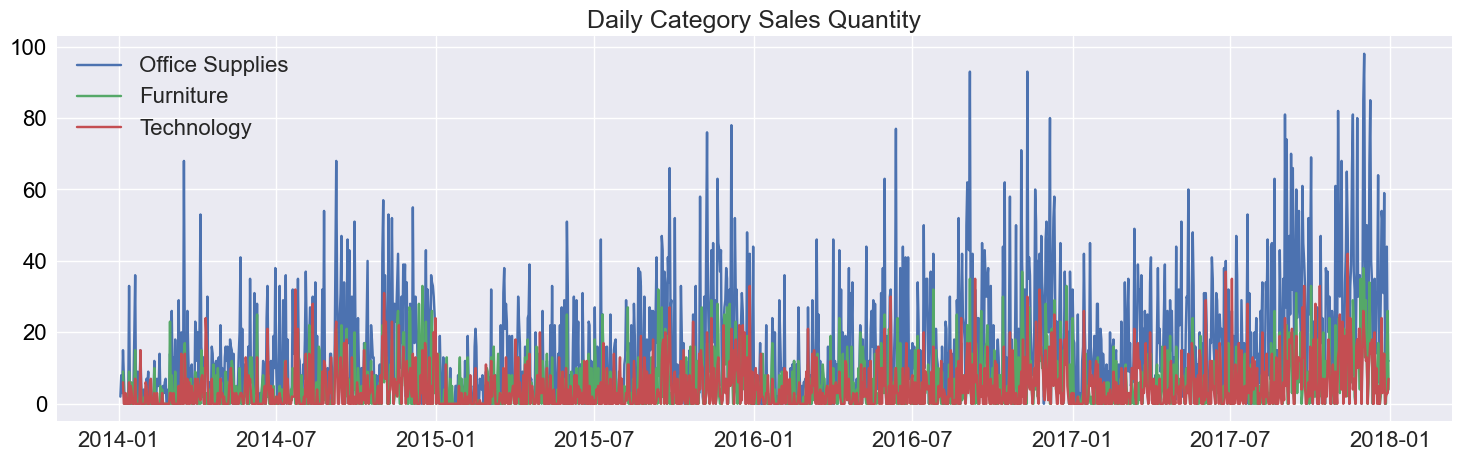

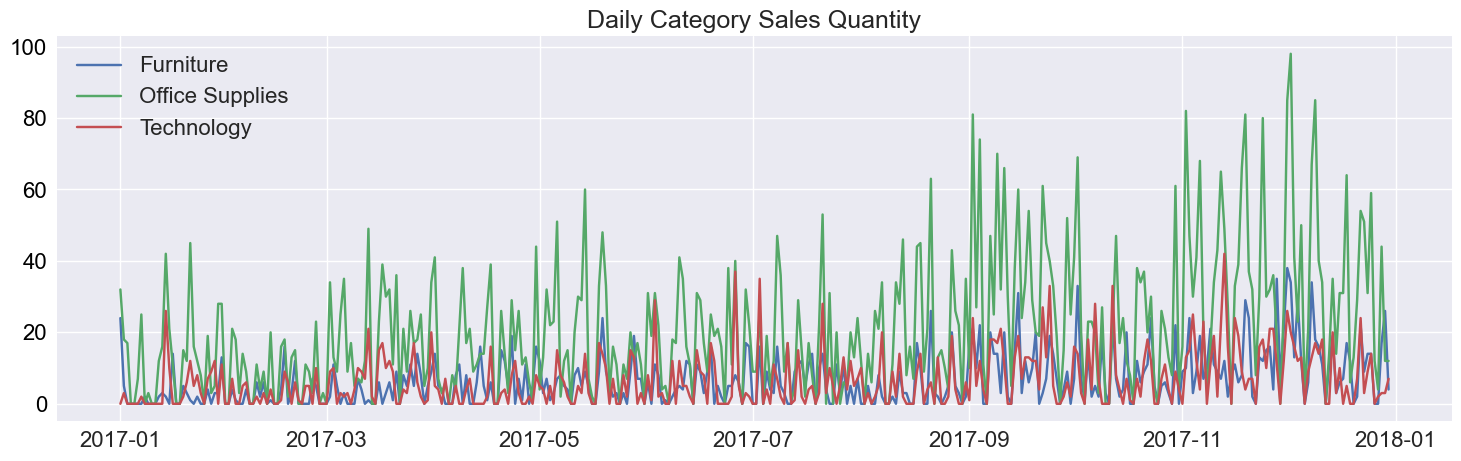

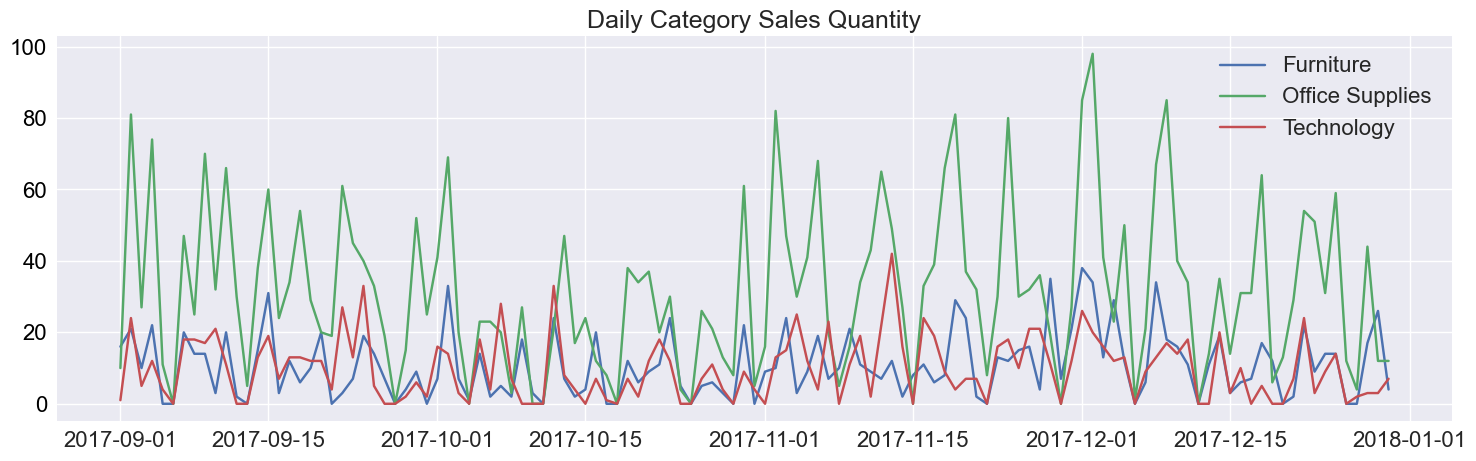

In [6]:

bp.lineplot(df_catsales,"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,1,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,9,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" ,
            title = "Daily Category Sales Quantity", figsize=(18,5))

## Wide (Multivariate) Format

In [7]:
dfXYw = df_catsales.copy()

def to_flat_columns(hier_cols):
    flat_cols=[]
    for clist in hier_cols:
        for n,ci in enumerate(clist):
            c = ci if n == 0 else c+"_"+ci 
        flat_cols.append(c)
    return flat_cols

dp = "Order Date" # demand period
dfXYw = dfXYw.pivot(index=dp, columns = "Category" , values = ["Quantity" , "Sales"] )
flat_cols = to_flat_columns(dfXYw.columns)
dfXYw.columns = flat_cols 
dfXYw = dfXYw.fillna(0)

dfXYw.head()

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Sales_Furniture,Sales_Office Supplies,Sales_Technology
Order Date,,,,,,
2014-01-03,0.0,2.0,0.0,0.000,16.448,0.00
2014-01-04,0.0,8.0,0.0,0.000,288.060,0.00
2014-01-05,0.0,3.0,0.0,0.000,19.536,0.00
2014-01-06,9.0,15.0,6.0,2573.820,685.340,1147.94
2014-01-07,3.0,7.0,0.0,76.728,10.430,0.00


## Univariate Forecast

In [9]:

dfXY = dfXYw[["Quantity_Furniture"]]


print('dfXY',end="")
display(dfXY.head())

ts_params = {
    "Npred":30,
    "Nhorizon":1,
    "Nlag":40,
    "minmax" :(0,None)}  

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfuv = sf.sforecast(y = y, ts_parameters=ts_params,model=xgb_model)

df_pred_uv = sfuv.forecast(dfXY)


print(f'\nmetrics = {sfuv.metrics}')
dfXY_pred_uv = dfXY.join(df_pred_uv)
display(dfXY_pred_uv)


dfXY

,Quantity_Furniture
Order Date,
2014-01-03,0.0
2014-01-04,0.0
2014-01-05,0.0
2014-01-06,9.0
2014-01-07,3.0


,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,
2014-02-12,2.0,NaN,NaN,NaN,NaN,NaN
2014-02-13,0.0,NaN,NaN,NaN,NaN,NaN
2014-02-14,0.0,NaN,NaN,NaN,NaN,NaN
2014-02-15,0.0,NaN,NaN,NaN,NaN,NaN
2014-02-16,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2017-12-26,NaN,0.0,7.795359,-7.795359,0.000000,25.518230
2017-12-27,NaN,0.0,5.819362,-5.819362,0.000000,23.542233
2017-12-28,NaN,17.0,10.800791,6.199209,0.698584,28.523662



metrics = {'Quantity_Furniture_pred': {'RMSE': 10.87581550378233, 'MAE': 8.69707449277242}}


,Quantity_Furniture,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,,
2014-01-03,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-12-26,0.0,NaN,0.0,7.795359,-7.795359,0.000000,25.518230
2017-12-27,0.0,NaN,0.0,5.819362,-5.819362,0.000000,23.542233
2017-12-28,17.0,NaN,17.0,10.800791,6.199209,0.698584,28.523662


In [36]:
pred_expected = np.array([11.14825916, 16.47620201, 15.51670933, 14.10373211, 8.29227543 ,14.59656048,
 15.01964188, 12.68975925, 19.6415062,   8.6744585,  12.3606863 ,  4.91769266,
 15.06090832 ,10.46361732 ,13.13412762,  6.82626009 ,17.09865952,  7.37598896,
 15.51855278 , 8.73959637 ,16.92628479 , 8.40623951, 10.60089779 ,13.41072845,
  8.79228687 , 7.79535913 , 5.81936169, 10.80079079 , 6.48547268 , 8.45924091])


pred_expected_p = pred_expected + 0.2
pred_expected_m = pred_expected - 0.2
pred_result = df_pred_uv["Quantity_Furniture_pred"].tail(30).values


assert (pred_result > pred_expected_m).all() , "univariate forecast failed pred_result > pred_expected_m"

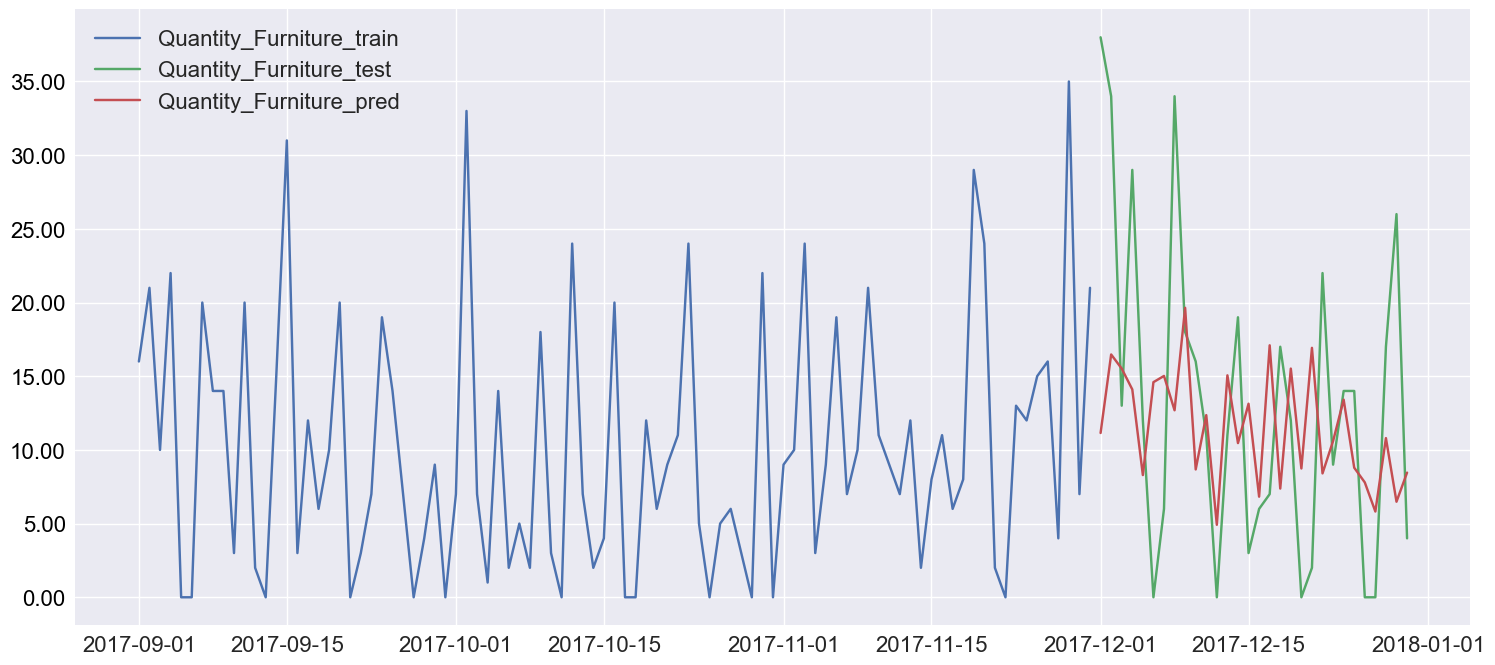

In [15]:

y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfuv = dfXY_pred_uv.reset_index().copy()
yfillbetween = (y+"_pred_lower",y+"_pred_upper")

d=datetime(2017,9,1)
bp.lineplot(dfuv[dfuv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8) , legend=True)

## Univariate Forecast with Covariates

In [47]:

print('dfXY',end="")
display(dfXY.head())


dfXY = dfXYw[["Quantity_Furniture","Quantity_Office Supplies", "Quantity_Technology" ]]
y = ["Quantity_Furniture"]
Npred = 30

ts_params = {
    "Npred":Npred,
    "Nhorizon":1,
    "Nlag":40,
    "minmax" :(0,None),
    "co_vars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]} 

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 
sfuvc = sf.sforecast(y = y, ts_parameters=ts_params,model=xgb_model)
df_pred_uvc = sfuvc.forecast(dfXY)

print(f'\nmetrics = {sfuvc.metrics}')
dfXY_pred_uvc = dfXY.join(df_pred_uvc)
display(dfXY_pred_uvc)

dfXY

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology
Order Date,,,
2014-01-03,0.0,2.0,0.0
2014-01-04,0.0,8.0,0.0
2014-01-05,0.0,3.0,0.0
2014-01-06,9.0,15.0,6.0
2014-01-07,3.0,7.0,0.0


,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,
2014-02-12,2.0,NaN,NaN,NaN,NaN,NaN
2014-02-13,0.0,NaN,NaN,NaN,NaN,NaN
2014-02-14,0.0,NaN,NaN,NaN,NaN,NaN
2014-02-15,0.0,NaN,NaN,NaN,NaN,NaN
2014-02-16,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2017-12-26,NaN,0.0,6.055835,-6.055835,0.000000,19.622014
2017-12-27,NaN,0.0,2.989914,-2.989914,0.000000,16.556093
2017-12-28,NaN,17.0,18.785179,-1.785179,11.204631,32.351358



metrics = {'Quantity_Furniture_pred': {'RMSE': 9.841539652729166, 'MAE': 7.386767991383871}}


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,,,,
2014-01-03,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,NaN,0.0,6.055835,-6.055835,0.000000,19.622014
2017-12-27,0.0,4.0,2.0,NaN,0.0,2.989914,-2.989914,0.000000,16.556093
2017-12-28,17.0,44.0,3.0,NaN,17.0,18.785179,-1.785179,11.204631,32.351358


[11.255541801452637, 13.590967178344727, 17.33194351196289, 18.17267608642578, 9.9024076461792, 7.018445014953613, 12.39219856262207, 14.338815689086914, 17.58784294128418, 10.145371437072754, 15.130827903747559, 13.139010429382324, 4.695201873779297, 16.284250259399414, 20.907461166381836, 5.7730817794799805, 10.660463333129883, 12.513736724853516, 7.995673179626465, 5.665019512176514, 14.63947582244873, 9.111043930053711, 7.6075334548950195, 8.155879020690918, 14.03388786315918, 6.055835247039795, 2.9899139404296875, 18.785179138183594, 19.470705032348633, 9.454106330871582]


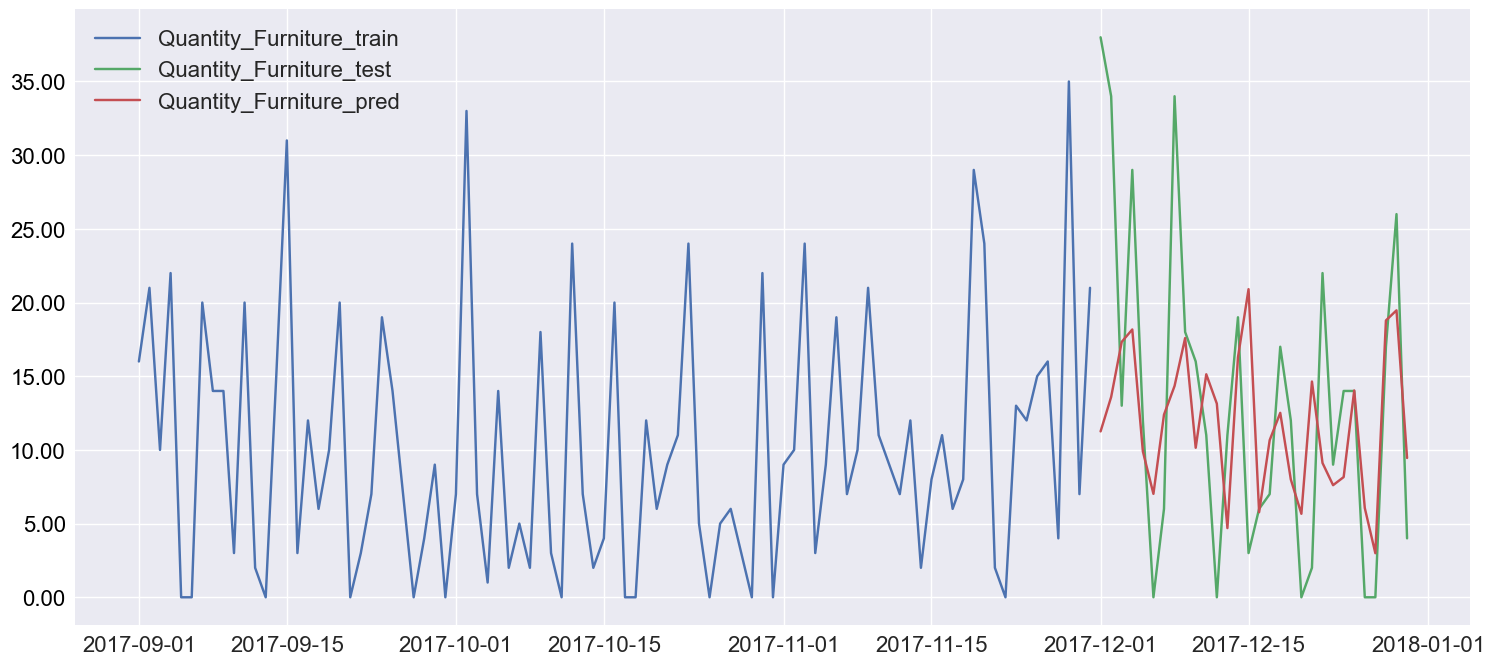

In [17]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfuvc = dfXY_pred_uvc.reset_index().copy()

d=datetime(2017,9,1)
bp.lineplot(dfuvc[dfuvc["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8))

## Multivariate Forecast

In [53]:
dfXY = dfXYw[["Quantity_Furniture","Quantity_Office Supplies", "Quantity_Technology" ]]




print('dfXY',end="")
display(dfXY.head())

y = [ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]
Npred = 30

ts_params = {
    "Npred":Npred,
    "Nhorizon":1,
    "Nlag":40,
    "minmax" :(0,None),
    "co_vars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]} 

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfmv = sf.sforecast(y = y, ts_parameters=ts_params,model=xgb_model)
df_pred_mv = sfmv.forecast(dfXY)

print(f'\nmetrics = {sfmv.metrics}')
dfXY_pred_mv = dfXY.join(df_pred_mv)
display(dfXY_pred_mv)

dfXY

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology
Order Date,,,
2014-01-03,0.0,2.0,0.0
2014-01-04,0.0,8.0,0.0
2014-01-05,0.0,3.0,0.0
2014-01-06,9.0,15.0,6.0
2014-01-07,3.0,7.0,0.0


,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper,Quantity_Office Supplies_train,Quantity_Office Supplies_test,Quantity_Office Supplies_pred,Quantity_Office Supplies_pred_error,Quantity_Office Supplies_pred_lower,Quantity_Office Supplies_pred_upper,Quantity_Technology_train,Quantity_Technology_test,Quantity_Technology_pred,Quantity_Technology_pred_error,Quantity_Technology_pred_lower,Quantity_Technology_pred_upper
Order Date,,,,,,,,,,,,,,,,,,
2014-02-12,2.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-02-13,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-02-14,0.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
2014-02-15,0.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-02-16,0.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,NaN,0.0,6.055835,-6.055835,0.000000,19.622014,NaN,12.0,30.671810,-18.671810,11.409154,65.602387,NaN,0.0,12.978919,-12.978919,1.492448,21.535302
2017-12-27,NaN,0.0,2.989914,-2.989914,0.000000,16.556093,NaN,4.0,4.507528,-0.507528,0.000000,39.438105,NaN,2.0,4.494198,-2.494198,0.000000,13.050582
2017-12-28,NaN,17.0,18.785179,-1.785179,11.204631,32.351358,NaN,44.0,30.113577,13.886423,10.850921,65.044154,NaN,3.0,12.835868,-9.835868,1.349397,21.392251



metrics = {'Quantity_Furniture_pred': {'RMSE': 9.841539652729166, 'MAE': 7.386767991383871}, 'Quantity_Office Supplies_pred': {'RMSE': 24.741110974219684, 'MAE': 17.99593949317932}, 'Quantity_Technology_pred': {'RMSE': 7.733705991418185, 'MAE': 6.571896306673685}}


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper,Quantity_Office Supplies_train,...,Quantity_Office Supplies_pred,Quantity_Office Supplies_pred_error,Quantity_Office Supplies_pred_lower,Quantity_Office Supplies_pred_upper,Quantity_Technology_train,Quantity_Technology_test,Quantity_Technology_pred,Quantity_Technology_pred_error,Quantity_Technology_pred_lower,Quantity_Technology_pred_upper
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,NaN,0.0,6.055835,-6.055835,0.000000,19.622014,NaN,...,30.671810,-18.671810,11.409154,65.602387,NaN,0.0,12.978919,-12.978919,1.492448,21.535302
2017-12-27,0.0,4.0,2.0,NaN,0.0,2.989914,-2.989914,0.000000,16.556093,NaN,...,4.507528,-0.507528,0.000000,39.438105,NaN,2.0,4.494198,-2.494198,0.000000,13.050582
2017-12-28,17.0,44.0,3.0,NaN,17.0,18.785179,-1.785179,11.204631,32.351358,NaN,...,30.113577,13.886423,10.850921,65.044154,NaN,3.0,12.835868,-9.835868,1.349397,21.392251


In [57]:
pred_result = df_pred_mv["Quantity_Technology_pred"].tail(30).values
print(list(pred_result))

pred_expected = np.array([16.838611602783203, 8.737680435180664, 9.872063636779785, 
             18.513700485229492, 11.806622505187988, 13.020414352416992, 12.018507957458496, 
            11.148112297058105, 10.787961959838867, 11.249581336975098, 11.84135627746582, 
            7.271737098693848, 3.3275129795074463, 18.205322265625, 17.844205856323242, 15.652249336242676, 
            11.320643424987793, 15.34378433227539, 2.9382543563842773, 3.6095008850097656, 6.671794891357422, 
            9.964138984680176, 10.439900398254395, 12.74950885772705, 5.510839462280273, 12.97891902923584, 
            4.494198322296143, 12.835867881774902, 6.102931499481201, 13.329137802124023])


pred_expected_p = pred_expected + 0.2
pred_expected_m = pred_expected - 0.2
pred_result = df_pred_mv["Quantity_Technology_pred"].tail(30).values


assert (pred_result > pred_expected_m).all() , "multivariate forecast with covariates failed pred_result > pred_expected_m"
assert (pred_result < pred_expected_p).all() , "multivariate forecast with covariates failed pred_result < pred_expected_p"

[16.838611602783203, 8.737680435180664, 9.872063636779785, 18.513700485229492, 11.806622505187988, 13.020414352416992, 12.018507957458496, 11.148112297058105, 10.787961959838867, 11.249581336975098, 11.84135627746582, 7.271737098693848, 3.3275129795074463, 18.205322265625, 17.844205856323242, 15.652249336242676, 11.320643424987793, 15.34378433227539, 2.9382543563842773, 3.6095008850097656, 6.671794891357422, 9.964138984680176, 10.439900398254395, 12.74950885772705, 5.510839462280273, 12.97891902923584, 4.494198322296143, 12.835867881774902, 6.102931499481201, 13.329137802124023]


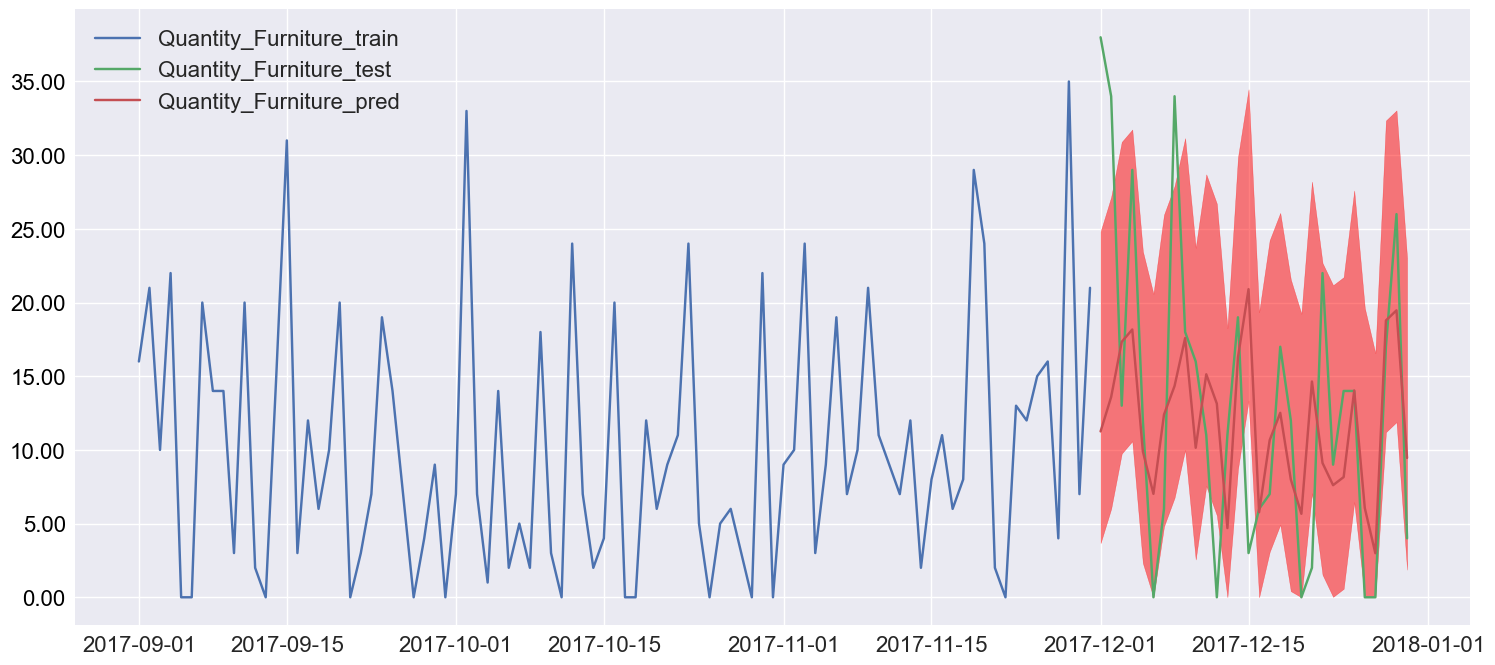

In [19]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfmv = dfXY_pred_mv.reset_index().copy()

yfillbetween = (y+"_pred_lower",y+"_pred_upper")

d=datetime(2017,9,1)
bp.lineplot(dfmv[dfmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , yfb=yfillbetween, figsize=(18,8) , legend=True)

In [21]:
import numpy as np
a = np.array([1, 2, 3])
b = a + 0.1
             

In [22]:
a < b

array([ True,  True,  True])

In [26]:
assert (a < b).all()